In [1]:
# Indlæs biblioteker 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

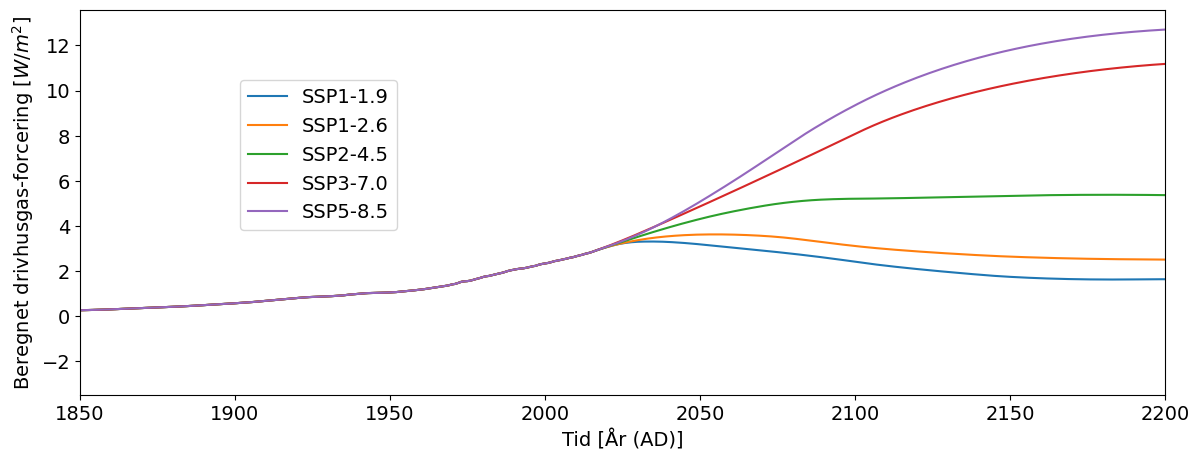

In [2]:
# Indlæser SSP drivhusgas-forceringsscenarier og plotter dem.
# Disse scenarier anvendes til IPCC's seneste rapport og bruges til at definere menneskeskabt strålingsforcering.

SSP=np.loadtxt('SSP_Paleo_GHG_Forcing_Scenarios.txt')   # Indlæser SSP scenarier
OceanHeat = np.genfromtxt('ohc_global_1955.txt',skip_header=8, skip_footer=2)
SeaTemp = np.loadtxt('sea-surface-temp_fig-1.csv', delimiter=',', skiprows=82)

fig_Profile , ax_Profile = plt.subplots ( figsize =(14 , 5) )     # Åbner en figur
l1, =ax_Profile.plot(SSP[:,0],SSP[:,1])                           # Tegner Scenario SSP1-1.9
l2, =ax_Profile.plot(SSP[:,0],SSP[:,2])                           # Tegner Scenario SSP1-2.6
l3, =ax_Profile.plot(SSP[:,0],SSP[:,3])                           # Tegner Scenario SSP2-4.5
l4, =ax_Profile.plot(SSP[:,0],SSP[:,4])                           # Tegner Scenario SSP3-7.0
l5, =ax_Profile.plot(SSP[:,0],SSP[:,5])                           # Tegner Scenario SSP5-8.5

fig_Profile.legend((l1,l2,l3,l4,l5),('SSP1-1.9','SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5'),loc=[0.2,0.5],fontsize=14)
ax_Profile.set_xlabel('Tid [År (AD)]',fontsize=14)
ax_Profile.set_ylabel('Beregnet drivhusgas-forcering '+r'[$W/m^2$]',fontsize=14)
ax_Profile.tick_params(which='major',labelsize=14)
ax_Profile.set (xlim=(1850,2200))
plt.savefig('SSP_GHG_Forcing_Scenarios.png',dpi=300, bbox_inches='tight')

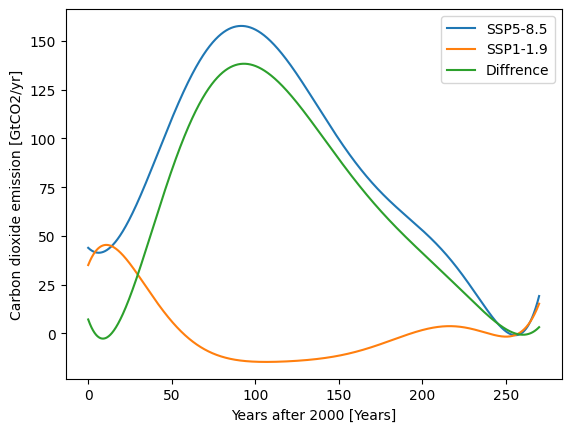

0.0008467876596878961


In [3]:
#Funktion der giver Gigaton carbondioxid vores solceller skal erstatte efter år 2000 til år 2250
def f(x):
    return 43.8809108-0.822596154*x+0.0693815243*x**2-0.000385655734*x**3-5.58257207*10**(-6)*x**4+6.56002888*10**(-8)*x**5-2.42439269*10**(-10)*x**6+3.07785205*10**(-13)*x**7
def f2(x):
    return 35.0322691+2.15186087*x-0.135149413*x**2+0.00251883660*x**3-2.32504086*10**(-5)*x**4+1.16041235*10**(-7)*x**5-2.98410405*10**(-10)*x**6+3.09163132*10**(-13)*x**7
def CO2(x):
    return (f(x)-f2(x))*0.21971830985*3.6641412039
#print(CO2(270))

t1 = np.arange(0.0, 270, 0.1)

plt.plot(t1,f(t1),label="SSP5-8.5")
plt.plot(t1,f2(t1),label="SSP1-1.9")
plt.plot(t1,CO2(t1),label="Diffrence")
plt.legend()
plt.xlabel("Years after 2000 [Years]")
plt.ylabel("Carbon dioxide emission [GtCO2/yr]")
plt.show()
def E(x):
    return (CO2(x)*10**12)/0.4

FS=1368                  # Solindstråling i W/m**2
StS = 4300               # Soltimer i Sahara
SE = 0.135               # Solcellers effectivitet

EPS = (StS*FS*SE)/1000   # Eneregi produceret pr. m^2 solceller i sahara om året i kWh

def AS(x):               # Berenger hvor mange km^2 der skal dækkes med solceller for at dække energibehov
    return (E(x)/EPS)*10**-6 

def f_sahara(x):         # Beregner andelen af jorden der skal dækkes med solceller
    return AS(x)/510100000

print(f_sahara(100))

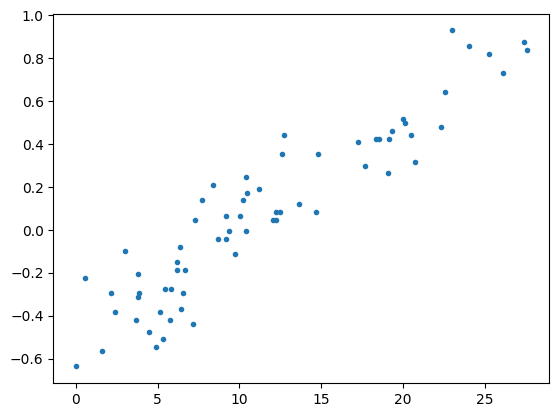

In [4]:
plt.plot(OceanHeat[:,1],SeaTemp[:,1], '.')
n=3
J = OceanHeat[:,1]*10**22
Te = SeaTemp[:,1]-SeaTemp[0,1]
R_T = np.zeros(22)
R_J = np.zeros(22)

for i in range(22):
    R_T[i] = np.average(Te[n*i:n*(i+1)])
    R_J[i] = np.average(J[n*i:n*(i+1)])

5.06421614424447e-24 1.6939213175454828e-24


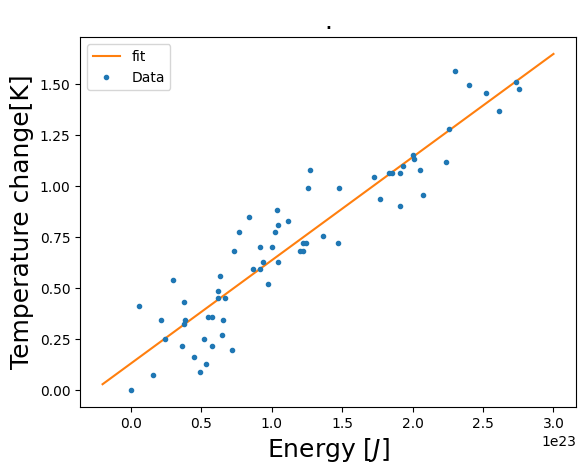

<Figure size 640x480 with 0 Axes>

In [5]:
def linear(x, m, c):
    return m*x + c

#guess = [1000, 1000, 0.94, 1.06, 0.1, 100, 100]
#names = ['A1', 'A2', 'mu1', 'mu2', 'sigma', 'm', 'c']

par, cov = curve_fit(linear, J, Te, absolute_sigma=True)
m , c = par
m_err, c_err = np.sqrt(np.diag(cov))


X = np.linspace(-0.2*10**23,3*10**23,1000)
y_model = linear(X, *par)

fig = plt.figure()
ax = plt.gca()
plt.errorbar(J, Te, fmt='.', label = "Data")
plt.plot(X, y_model, label = "fit")
plt.legend()
plt.xlabel(r"Energy [$J$]", fontsize=18)
plt.ylabel("Temperature change[K]", fontsize=18)
plt.title(f".", fontsize=18)
plt.figure()
print(m, m_err)

In [6]:
eps0=0.63564    # Emissivitet af Ocean-Jord atmosfære ved T0=288K
deps_dT=-0.0041 # Ændring i emissivitet per K temperaturændring

REarth=6371e3   # Radius af Jordens i m

dWater=150      # Dybden af det vel blandede lag af havet i m 
AOcean=0.05     # Gennemsnitlig albedo af havet
ACloud=0.5      # Gennemsnitlig albedo af skyer
Asolceller=0.1
Aørken=0.4
def A(x):
    return (AOcean+ACloud)/2+(Asolceller-Aørken)*f_sahara(x)   # Her antages at skyer dækker halvdelen af overfladen og gennemsnitlig albedo udregnes

rhoWater=1000   # Densitet af vand i kg/m**3
cWater=4.18e3   # Specifik varmekapacitet af vand i J/(kg)/(K)

#COcean=dWater*cWater*rhoWater*4*np.pi*REarth**2   # Total varmekapacitet af den velblandede del af verdenshavet
COcean = 1/m

T0=288                   # Start temperatur for Ocean-Jord planeten

SBconst=5.67e-8          # Stefan-Boltzmanns konstant i W/(m**2)/(K**4)

secyear=365.25*24*60*60  # Antal sekunder i et år
t0 = 1850                # Start år

print(COcean)

1.974639256139392e+23


In [7]:
N=6500              # Antal tidsskridt
dt=1/10              # Tidsskridt-størrelse i år

T=np.zeros(N)         # Array til havtemperatur-værdier
EOcean=np.zeros(N)    # Array til værdier for havets varmeindhold
ELW=np.zeros(N)       # Array til energien af den udstrålede langbølge-stråling

# Beregning med ændring af albedo

In [8]:
T[0]=T0                   # Initialisering af temperatur
EOcean[0]=COcean*T0       # Initialisering af havets varme indhold

#ESW = np.ones(N) * FS*(1-A(15))*np.pi*REarth**2*dt*secyear  #Indkommende kortbølge-stråling beregnes

t = np.linspace(t0, t0 + N*dt, N) #Tids-array


# Interpolering af SSP drivhusgas-forceringsscenarier til de angivne tidsskridt
scenarios = 1                                             # Her vælges, hvilket SSP-scenarie man anvender!
SSPint=interp1d(SSP[:,0],SSP[:,scenarios])                # Lineær interpolations-funktion defineres fro det valgte scenarie

human_ghg_on = True # Tænd og sluk for meneskeskabt drivhusgas-forcering

eps_temp_dep = True # Tænd og sluk for temperatur afhængig emissivitet

for i in range(1,N): #Løkke over alle tidsskridt "i" fra skridt 1 til skridt N
    
    if eps_temp_dep:
        # temperaturafhængig emissivitet
        eps = eps0 + deps_dT*(T[i-1]-T0) # 
    
    else:
        # konstant emissivitet
        eps = eps0

    if human_ghg_on:
        # Indlæsning af drivhusgas-forcering og udregning af, hvor meget den er øget siden tiden t0, hvor modelkørslen startes 
        dF = SSPint(t[i])-SSPint(t0)
    
    else:
        # Ingen drivhusgas-forcering
        dF = 0
    if i<15000 or i>41000:
        ESW = np.ones(N) * FS*(1-A(15))*np.pi*REarth**2*dt*secyear  #Indkommende kortbølge-stråling beregnes
    else:
        ESW = np.ones(N)*FS*(1-A(i*(250/N)))*np.pi*REarth**2*dt*secyear
    
    # Beregning af den langbølge-stråling fra havets overflade, der passerer gennem atmosfæren til tidsskridt "i"
    ELW[i]=((eps)*SBconst*(T[i-1]**4)-dF) *4*np.pi*(REarth**2)*dt*secyear
    
    EOcean[i]=ESW[i]-ELW[i]+EOcean[i-1]           # Beregning af havets varme indhold for tidsskridt "i"
    T[i]=EOcean[i]/COcean                         # Beregning af ocean-temperaturen for tidsskridt "i"

C:\Users\lucq0\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lucq0\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


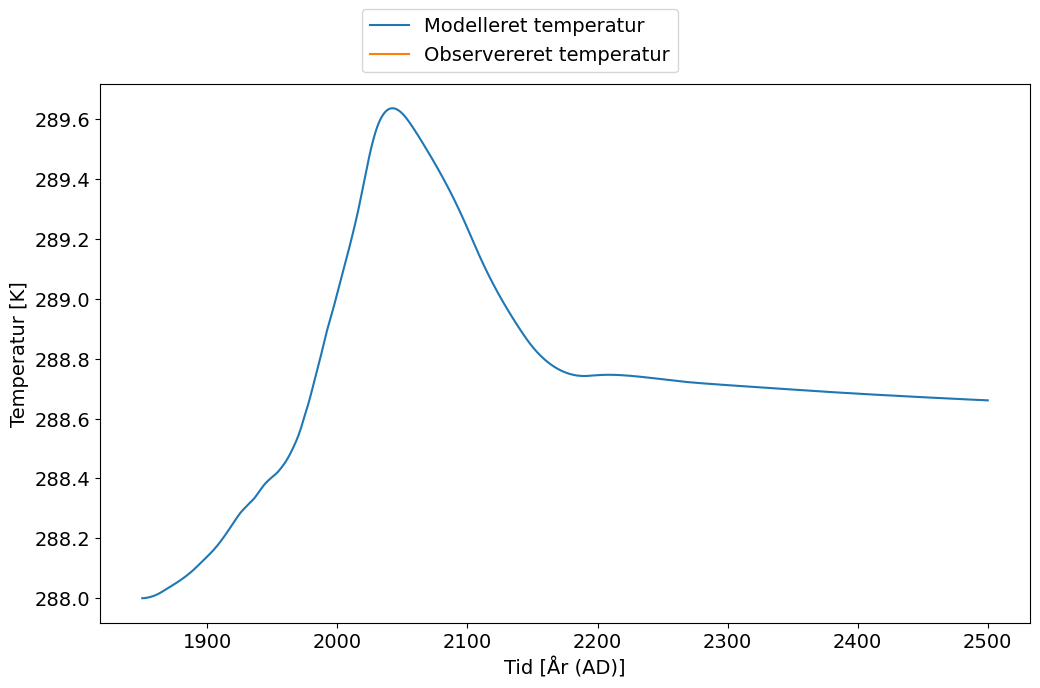

In [9]:
# Figur, der viser modelleret havtemperatur for det valgte scenarie vs den observerede hav temperatur

ObsOceanT=np.loadtxt('HadSST4_ocean_annual.txt')                                # Indlæsning af observeret havtemperatur


fig_Profile , ax_Profile = plt.subplots ( figsize =(12 , 7) )                   # Åbning af et figur-vindue

l1, =ax_Profile.plot(t,T)                                                       # Plotter modelleret hav temperatur vs. tid

l2, =ax_Profile.plot(ObsOceanT[:,0],ObsOceanT[:,1]+np.mean(T[11_000:14_000]))   # Ploter observeret hav temperatur vs. tid (tilpasset til at matche model middel for 1961-90)

fig_Profile.legend((l1,l2),('Modelleret temperatur','Observereret temperatur'),'upper center',fontsize=14)
ax_Profile.set_xlabel('Tid [År (AD)]',fontsize=14)
ax_Profile.set_ylabel('Temperatur [K]',fontsize=14)
ax_Profile.tick_params(which='major',labelsize=14)

# Beregninger uden ændring af albedo

C:\Users\lucq0\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lucq0\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


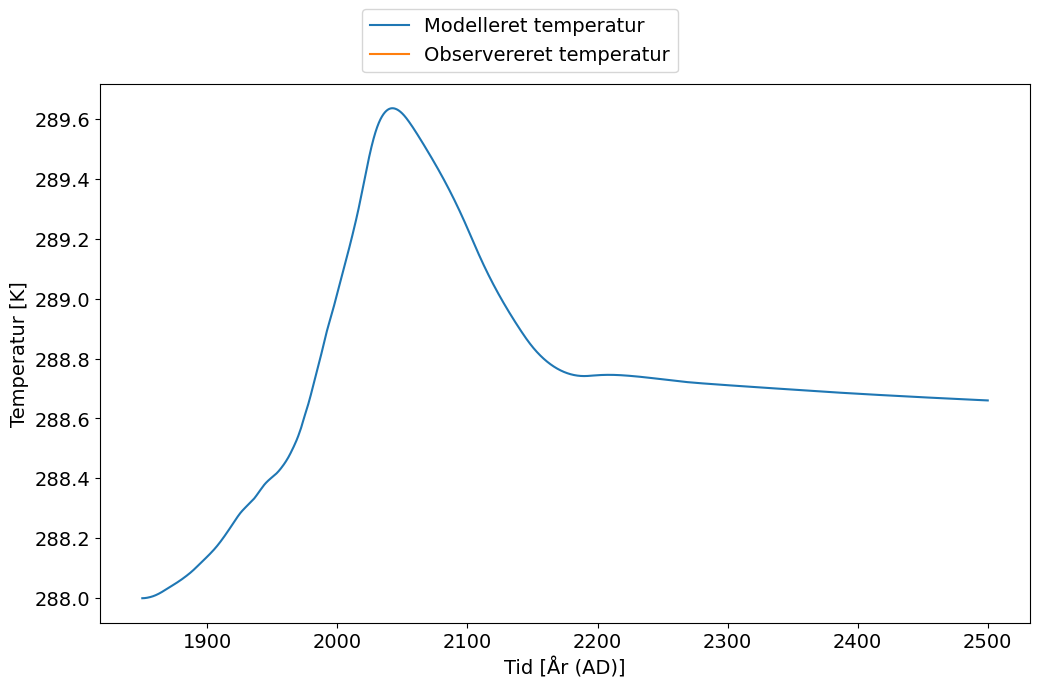

In [10]:
T[0]=T0                   # Initialisering af temperatur
EOcean[0]=COcean*T0       # Initialisering af havets varme indhold

ESW = np.ones(N)*FS*(1-0.275)*np.pi*REarth**2*dt*secyear  #Indkommende kortbølge-stråling beregnes

t = np.linspace(t0, t0 + N*dt, N) #Tids-array


# Interpolering af SSP drivhusgas-forceringsscenarier til de angivne tidsskridt
scenarios = 1                                             # Her vælges, hvilket SSP-scenarie man anvender!
SSPint=interp1d(SSP[:,0],SSP[:,scenarios])                # Lineær interpolations-funktion defineres fro det valgte scenarie

human_ghg_on = True # Tænd og sluk for meneskeskabt drivhusgas-forcering

eps_temp_dep = True # Tænd og sluk for temperatur afhængig emissivitet

for i in range(1,N): #Løkke over alle tidsskridt "i" fra skridt 1 til skridt N
    
    if eps_temp_dep:
        # temperaturafhængig emissivitet
        eps = eps0 + deps_dT*(T[i-1]-T0) # 
    
    else:
        # konstant emissivitet
        eps = eps0

    if human_ghg_on:
        # Indlæsning af drivhusgas-forcering og udregning af, hvor meget den er øget siden tiden t0, hvor modelkørslen startes 
        dF = SSPint(t[i])-SSPint(t0)
    
    else:
        # Ingen drivhusgas-forcering
        dF = 0
    
    # Beregning af den langbølge-stråling fra havets overflade, der passerer gennem atmosfæren til tidsskridt "i"
    ELW[i]=((eps)*SBconst*(T[i-1]**4)-dF) *4*np.pi*(REarth**2)*dt*secyear
    
    EOcean[i]=ESW[i]-ELW[i]+EOcean[i-1]           # Beregning af havets varme indhold for tidsskridt "i"
    T[i]=EOcean[i]/COcean                         # Beregning af ocean-temperaturen for tidsskridt "i"
    
    # Figur, der viser modelleret havtemperatur for det valgte scenarie vs den observerede hav temperatur

ObsOceanT=np.loadtxt('HadSST4_ocean_annual.txt')                                # Indlæsning af observeret havtemperatur


fig_Profile , ax_Profile = plt.subplots ( figsize =(12 , 7) )                   # Åbning af et figur-vindue

l1, =ax_Profile.plot(t,T)                                                       # Plotter modelleret hav temperatur vs. tid

l2, =ax_Profile.plot(ObsOceanT[:,0],ObsOceanT[:,1]+np.mean(T[11_000:14_000]))   # Ploter observeret hav temperatur vs. tid (tilpasset til at matche model middel for 1961-90)

fig_Profile.legend((l1,l2),('Modelleret temperatur','Observereret temperatur'),'upper center',fontsize=14)
ax_Profile.set_xlabel('Tid [År (AD)]',fontsize=14)
ax_Profile.set_ylabel('Temperatur [K]',fontsize=14)
ax_Profile.tick_params(which='major',labelsize=14)

In [11]:
B = 100

DATA = np.zeros((B,N))

for j in range(B):
    C = np.random.normal(m,m_err)

    DATA[j,0]=T0                   # Initialisering af temperatur
    EOcean[0]=T0/C       # Initialisering af havets varme indhold

    #ESW = np.ones(N) * FS*(1-A(15))*np.pi*REarth**2*dt*secyear  #Indkommende kortbølge-stråling beregnes

    t = np.linspace(t0, t0 + N*dt, N) #Tids-array


    # Interpolering af SSP drivhusgas-forceringsscenarier til de angivne tidsskridt
    scenarios = 1                                             # Her vælges, hvilket SSP-scenarie man anvender!
    SSPint=interp1d(SSP[:,0],SSP[:,scenarios])                # Lineær interpolations-funktion defineres fro det valgte scenarie

    human_ghg_on = True # Tænd og sluk for meneskeskabt drivhusgas-forcering

    eps_temp_dep = True # Tænd og sluk for temperatur afhængig emissivitet

    for i in range(1,N): #Løkke over alle tidsskridt "i" fra skridt 1 til skridt N

        if eps_temp_dep:
            # temperaturafhængig emissivitet
            eps = eps0 + deps_dT*(DATA[j,i-1]-T0) # 

        else:
            # konstant emissivitet
            eps = eps0

        if human_ghg_on:
            # Indlæsning af drivhusgas-forcering og udregning af, hvor meget den er øget siden tiden t0, hvor modelkørslen startes 
            dF = SSPint(t[i])-SSPint(t0)

        else:
            # Ingen drivhusgas-forcering
            dF = 0
        if i<15000 or i>41000:
            ESW = np.ones(N) * FS*(1-A(15))*np.pi*REarth**2*dt*secyear  #Indkommende kortbølge-stråling beregnes
        else:
            ESW = np.ones(N)*FS*(1-A(i*(250/N)))*np.pi*REarth**2*dt*secyear

        # Beregning af den langbølge-stråling fra havets overflade, der passerer gennem atmosfæren til tidsskridt "i"
        ELW[i]=((eps)*SBconst*(DATA[j,i-1]**4)-dF) *4*np.pi*(REarth**2)*dt*secyear

        EOcean[i]=ESW[i]-ELW[i]+EOcean[i-1]           # Beregning af havets varme indhold for tidsskridt "i"
        DATA[j,i]=EOcean[i]*C                         # Beregning af ocean-temperaturen for tidsskridt "i"

(array([ 1.,  6.,  6., 17., 20., 20.,  7., 17.,  4.,  2.]),
 array([288.00000176, 288.00000279, 288.00000382, 288.00000485,
        288.00000588, 288.00000691, 288.00000794, 288.00000898,
        288.00001001, 288.00001104, 288.00001207]),
 <BarContainer object of 10 artists>)

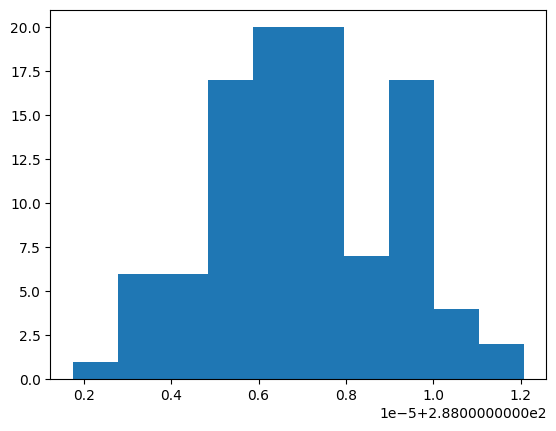

In [12]:
plt.hist(DATA[:,1])

In [13]:
U_T = np.zeros(6500)

for i in range(6500):
    U_T[i] = np.std(DATA[:,i])/10
    

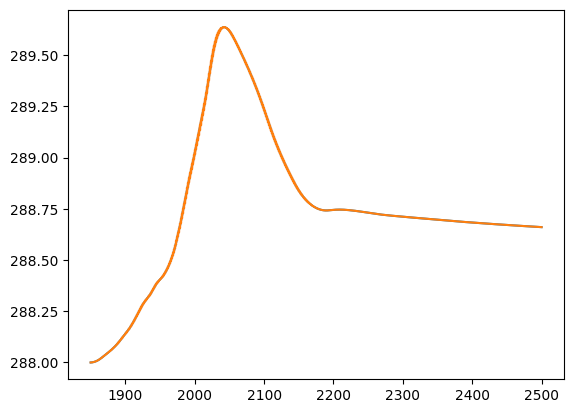

In [14]:
plt.plot(t,T)
plt.errorbar(t,T,yerr=U_T)
plt.show()

In [15]:
print(U_T)

[0.00000000e+00 2.03428151e-07 4.67303798e-07 ... 6.61306077e-05
 6.60855980e-05 6.60382370e-05]
